In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_gaussians(data, num_points=None, title=None, xlim=(-5,5), ylim=(-5,5)):
    fig, ax = plt.subplots(1,1,figsize=(2,2))
    x = data[:num_points,0]
    y = data[:num_points,1]
    z = stats.gaussian_kde(np.vstack([x,y]))(np.vstack([x,y]))
    plt.scatter(x, y, c=z, s=0.2, cmap='jet')
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.title(title, fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()

def plot_trajs(trajectories, num_sampling_steps, num_points=None, title=None, xlim=(-5,5), ylim=(-5,5)):
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    for i in range(num_sampling_steps): 
        plt.scatter(trajectories[i][:num_points,0], trajectories[i][:num_points,1], s=0.1, color='gray', alpha=0.3)
    plt.scatter(trajectories[0][:num_points,0], trajectories[0][:num_points,1], s=10, color='red', alpha=0.6)
    plt.scatter(trajectories[-1][:num_points,0], trajectories[-1][:num_points,1], s=10, color='blue', alpha=0.6)
    plt.show()

# Flow-Matching

#====================================================================================
INFO: created directory: ../results/smeared_gaussians.FlowMatch.MLP.2023.10.05_17h43
#====================================================================================
+--------------------+--------------------------+
| Parameters         | Values                   |
+--------------------+--------------------------+
| features           | ['x', 'y']               |
| data_name          | smeared_gaussians        |
| num_points         | 20000                    |
| dim_input          | 2                        |
| noise_cov          | [[0.3, 0.2], [0.2, 0.5]] |
| preprocess         | []                       |
| cuts               | x: [-inf, inf]           |
|                    | y: [-inf, inf]           |
| device             | cpu                      |
| data_split_fracs   | [0.8, 0.2, 0.0]          |
| batch_size         | 2000                     |
| epochs             | 300                 

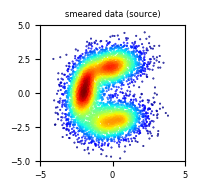

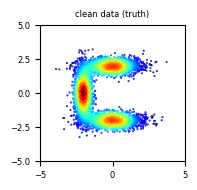

In [54]:

from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.configs.deconvolution_configs import Deconvolution_Gauss_MLP_FlowMatch as Configs

configs = Configs(data_name = 'smeared_gaussians',
                features = ['x', 'y'],
                num_points = 20000,
                sigma = 0.0001,
                noise_cov = [[0.3, 0.2],
                             [0.2, 0.5]],
                data_split_fracs = [0.8, 0.2, 0.0],
                epochs = 300,
                batch_size = 2000,
                lr = 1e-3,
                dim_hidden = 64, 
                device = 'cpu',
                solver='midpoint',
                num_sampling_steps=200,
                seed = 12345
                )
                
configs.set_workdir(path='../results', save_config=True)

from DynGenModels.datamodules.deconvolution.datasets import SmearedGaussDataset
from DynGenModels.datamodules.deconvolution.dataloader import ToysDataLoader 

toy_gauss = SmearedGaussDataset(configs)
dataloader = ToysDataLoader(toy_gauss, configs)

plot_gaussians(toy_gauss.smeared, title='smeared data (source)', num_points=6000)
plot_gaussians(toy_gauss.truth, title='clean data (truth)', num_points=6000)


In [4]:
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.deconvolution import DeconvolutionFlowMatching

mlp = MLP(configs)
cfm = DynGenModelTrainer(dynamics=DeconvolutionFlowMatching(mlp, configs), 
                         dataloader=dataloader,
                         configs=configs)

cfm.train()

INFO: number of training parameters: 8706


epochs:   0%|          | 0/300 [00:00<?, ?it/s]

INFO: neural ODE solver with midpoint method and steps=200


/Users/dario/anaconda3/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


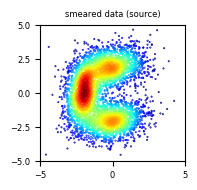

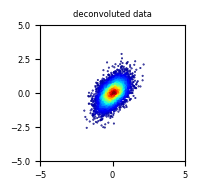

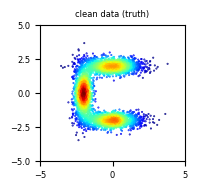

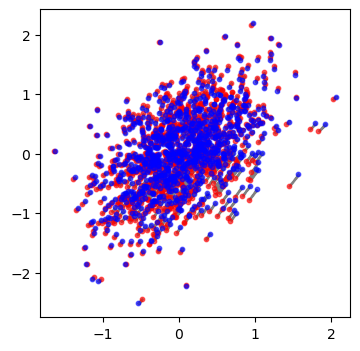

In [5]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline as Pipeline

noise = torch.distributions.MultivariateNormal(torch.zeros(2), torch.Tensor(configs.noise_cov)).sample((5000,))
pipeline = Pipeline(trained_model=cfm, source_input=noise , configs=configs)


#...plot densities:

plot_gaussians(dataset.smeared, title='smeared data (source)', num_points=len(pipeline.target))
plot_gaussians(pipeline.target, title='deconvoluted data')
plot_gaussians(dataset.truth, title='clean data (truth)', num_points=len(pipeline.target))

#...plot trajectories:

num_points=1000
fig, ax = plt.subplots(1,1, figsize=(4,4))
for i in range(configs.num_sampling_steps): 
    plt.scatter(pipeline.trajectories[i][:num_points,0], pipeline.trajectories[i][:num_points,1], s=0.1, color='gray', alpha=0.3)
plt.scatter(pipeline.trajectories[0][:num_points,0], pipeline.trajectories[0][:num_points,1], s=10, color='red', alpha=0.6)
plt.scatter(pipeline.trajectories[-1][:num_points,0], pipeline.trajectories[-1][:num_points,1], s=10, color='blue', alpha=0.6)
plt.show()

# Conditional Flow-Matching

#===============================================================================
INFO: created directory: ../results/ToyGaussians.FlowMatch.MLP.2023.10.05_19h34
#===============================================================================
+--------------------+--------------------------+
| Parameters         | Values                   |
+--------------------+--------------------------+
| features           | ['x', 'y']               |
| data_name          | ToyGaussians             |
| num_points         | 20000                    |
| dim_input          | 2                        |
| noise_cov          | [[0.1, 0.1], [0.1, 1.0]] |
| preprocess         | []                       |
| cuts               | x: [-inf, inf]           |
|                    | y: [-inf, inf]           |
| device             | cpu                      |
| data_split_fracs   | [0.8, 0.2, 0.0]          |
| batch_size         | 256                      |
| epochs             | 1000                     |
| lr    

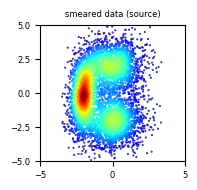

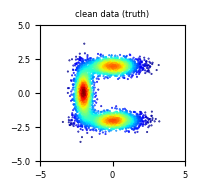

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_gaussians(data, num_points=None, title=None, xlim=(-5,5), ylim=(-5,5)):
    fig, ax = plt.subplots(1,1,figsize=(2,2))
    x = data[:num_points,0]
    y = data[:num_points,1]
    z = stats.gaussian_kde(np.vstack([x,y]))(np.vstack([x,y]))
    plt.scatter(x, y, c=z, s=0.2, cmap='jet')
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.title(title, fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()

def plot_trajs(trajectories, num_sampling_steps, num_points=None, title=None, xlim=(-5,5), ylim=(-5,5)):
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    for i in range(num_sampling_steps): 
        plt.scatter(trajectories[i][:num_points,0], trajectories[i][:num_points,1], s=0.1, color='gray', alpha=0.3)
    plt.scatter(trajectories[0][:num_points,0], trajectories[0][:num_points,1], s=10, color='red', alpha=0.6)
    plt.scatter(trajectories[-1][:num_points,0], trajectories[-1][:num_points,1], s=10, color='blue', alpha=0.6)
    plt.show()

from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.configs.deconvolution_configs import Deconvolution_Gauss_MLP_FlowMatch as Configs

configs = Configs(data_name = 'ToyGaussians',
                features = ['x', 'y'],
                num_points = 20000,
                sigma = 0.0001,
                noise_cov = [[0.1, 0.1],
                             [0.1, 1.0]],
                data_split_fracs = [0.8, 0.2, 0.0],
                epochs = 1000,
                batch_size = 256,
                lr = 1e-3,
                dim_hidden = 128, 
                device = 'cpu',
                solver='midpoint',
                num_sampling_steps=200,
                seed = 12345
                )
                
configs.set_workdir(path='../results', save_config=True)

from DynGenModels.datamodules.deconvolution.datasets import SmearedGaussDataset
from DynGenModels.datamodules.deconvolution.dataloader import ToysDataLoader 

toy_gauss = SmearedGaussDataset(configs)
dataloader = ToysDataLoader(toy_gauss, configs)

plot_gaussians(toy_gauss.smeared, title='smeared data (source)', num_points=6000)
plot_gaussians(toy_gauss.truth, title='clean data (truth)', num_points=6000)


In [21]:
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.deconvolution import DeconvolutionCondMatching

mlp = MLP(configs)
dynamics = DeconvolutionCondMatching(mlp, configs)
cfm = DynGenModelTrainer(dynamics=dynamics, 
                         dataloader=dataloader,
                         configs=configs)
cfm.train()

INFO: number of training parameters: 33794


epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

In [24]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline as Pipeline
pipeline = Pipeline(trained_model=cfm, source_input=toy_gauss.smeared, configs=configs)

INFO: neural ODE solver with midpoint method and steps=200


/Users/dario/anaconda3/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


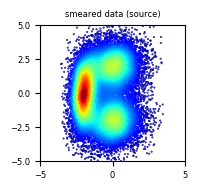

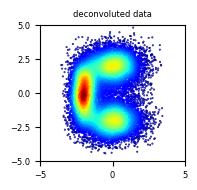

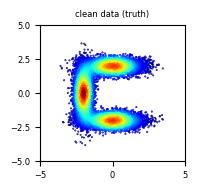

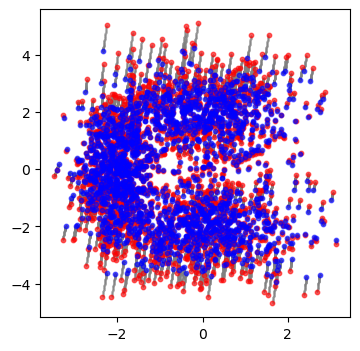

In [25]:
#...plot densities:

plot_gaussians(toy_gauss.smeared, title='smeared data (source)', num_points=len(pipeline.target))
plot_gaussians(pipeline.target, title='deconvoluted data')
plot_gaussians(toy_gauss.truth, title='clean data (truth)', num_points=len(pipeline.target))

#...plot trajectories:

num_points=1000
plot_trajs(pipeline.trajectories, configs.num_sampling_steps, num_points=2000)
